In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import tarfile
import imageio
import cv2
import glob
import os

import umap
import MulticoreTSNE
import fitsne

### Pull the data from the internet and write it to a file then unpack the file to disk.

Don't bother running this if you've already downloaded the dataset. 

We are unpacking the file into the directory that the notebook is running in.  Don't worry the coil-100 dataset should only take a few minutes to download on a good connection.

In [2]:
%%time
if not os.path.exists('coil-100'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.tar.gz')
    with open("coil_100.tar.gz", "wb") as code:
        code.write(results.content)

    images_zip = tarfile.open('coil_100.tar.gz', mode='r:gz')
    images_zip.extractall()

CPU times: user 79 µs, sys: 54 µs, total: 133 µs
Wall time: 146 µs


### Read our images from disk via the wonders of imageio.

They are read in as 128x128x3 ndarrays.  We make use of flatten to collapse them down to  a list of 7202, 49152 dimensional vectors.

In [3]:
feature_vectors = []
filelist = glob.glob('./coil-100/*.ppm')
for filename in filelist:
    im = cv2.imread(filename)
    feature_vectors.append(im.flatten())

### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

In [4]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

### The pandas data frame here would be too expensive both in time and memory to construct

In [5]:
%%time
data = np.vstack(feature_vectors).astype(np.float64, order='C')
print(data.shape)

(7200, 49152)
CPU times: user 1.16 s, sys: 2.26 s, total: 3.42 s
Wall time: 4.53 s


### Now let's use UMAP to embed these points into a two dimensional space.

A little parameter tweaking is required here in order find a particularly attractive embedding of our space.

In [6]:
fit = umap.UMAP(n_neighbors=5, random_state=42, min_dist=0.5, n_epochs=1000)
%time u = fit.fit_transform(data)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/umap_learn-0.3.2-py3.5.egg/umap/spectral.py:229: UserWarning: Embedding 26 connected components using meta-embedding (experimental)
/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 1min 5s, sys: 15.3 s, total: 1min 20s
Wall time: 1min 23s


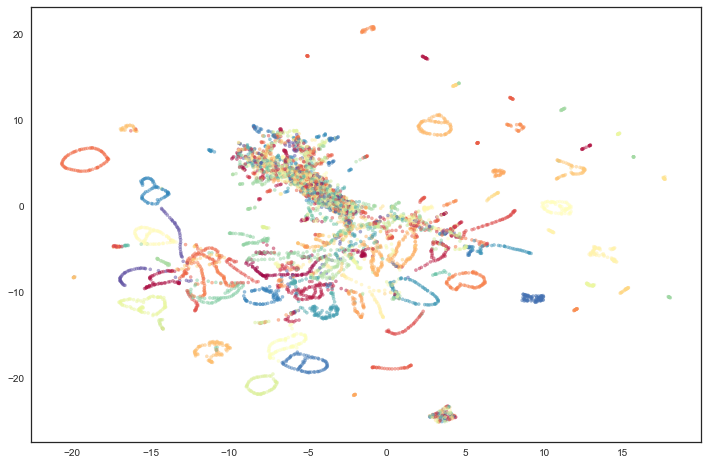

In [7]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="Spectral", s=10, alpha=0.5)

We see that are are able to preserve a number of the high dimensional structures within this data set.  

### Now we need to run t-SNE on our data

In [8]:
fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, random_state=42)
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 11min 59s, sys: 13.7 s, total: 12min 13s
Wall time: 12min 14s


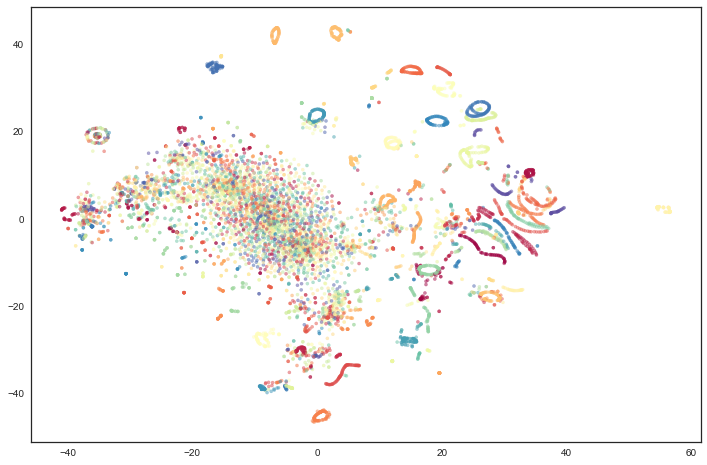

In [9]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="Spectral", s=10, alpha=0.5)

## FIt-SNE

In [10]:
%time u_fitsne = fitsne.FItSNE(data, nthreads=1, rand_seed=42)

CPU times: user 41min 36s, sys: 47.9 s, total: 42min 24s
Wall time: 43min 28s


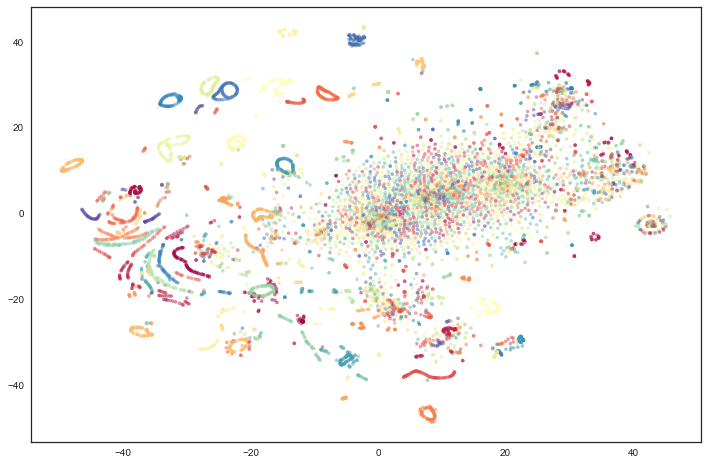

In [11]:
plt.scatter(u_fitsne[:,0], u_fitsne[:,1], c=labels, cmap="Spectral", s=10, alpha=0.5)

In [12]:
np.save('fitsne_coil100_embedding1.npy', u_fitsne)

In [13]:
output = pd.DataFrame(u_fitsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil100_fitsne1.csv')